# 프로젝트 : 폐렴 진단기 성능개선
|평가문항|상세기준|
|:---|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. ResNet 모델을 구현 하였다|Resnet 의 Residual block을 구현하고 학습의 경우 1에폭만 진행하여도 인정|

# 목차
1. 실험환경 Set-up
2. 데이터 준비하기
3. 데이터 시각화
4. 모델 구성
5. 데이터 imbanlance 처리
6. 모델 훈련
7. 결과 확인 및 시각화
8. 폐렴 진단기 성능 개선
    - ResNet-18 알고리즘
    - Data augmentation
    - Hyperparameter

## 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [43]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
# 하이퍼 파라미터 두 변수
BATCH_SIZE = 16
EPOCHS = 10

In [5]:
# 데이터 사이즈 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('training dataset: ', len(train_filenames))
print('test dataset: ', len(test_filenames))
print('validation dataset: ', len(val_filenames))

training dataset:  5216
test dataset:  624
validation dataset:  16


## 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다 (원래 validation set이 너무 적어서 늘리기 위함)
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('training dataset: ', len(train_filenames))
print('validation dataset: ', len(val_filenames))

training dataset:  4185
validation dataset:  1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1073-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

print('정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.')

Normal images count in training set: 1090
Pneumonia images count in training set: 3095
정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 라벨 데이터를 만들어 주는 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 제각기 다른 이미지 형식을 알맞은 형식으로 통일한다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [31]:
# train & validation 나누기
train_ds_orig = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_orig = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 이미지 사이즈와 라벨 확인
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
# 테스트 데이터 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print('Testing images count: ', TEST_IMAGE_COUNT)

Testing images count:  624


## 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

In [32]:
# 데이터 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치 설정
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    return ds

train_ds = prepare_for_training(train_ds_orig)
val_ds = prepare_for_training(val_ds_orig)

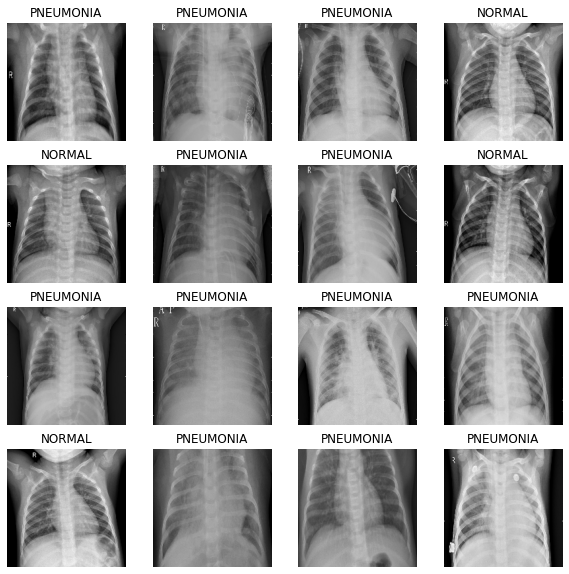

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy()) 

## 4. 모델 구성
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
# Batch normalization과 dropout regularization 둘 다 적용
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
# model build
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다.
recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [22]:
# weight balancing: training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


## 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [23]:
with tf.device('/GPU:0'): # GPU 선택
    model = build_model() # 미리 정한 model 선언

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', # adam
        loss='binary_crossentropy', # 라벨이 2가지 뿐이라
        metrics=METRICS # accuracy, precision, recall
    )

# 변수, 데이터셋을 파라미터에 넣고 학습 fit 
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 69s 209ms/step - loss: 0.3645 - accuracy: 0.8293 - precision: 0.9608 - recall: 0.8019 - val_loss: 0.6013 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 205ms/step - loss: 0.2151 - accuracy: 0.9131 - precision: 0.9732 - recall: 0.9073 - val_loss: 1.0481 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 207ms/step - loss: 0.2069 - accuracy: 0.9248 - precision: 0.9744 - recall: 0.9227 - val_loss: 0.6054 - val_accuracy: 0.7644 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 54s 209ms/step - loss: 0.1891 - accuracy: 0.9294 - precision: 0.9784 - recall: 0.9248 - val_loss: 0.0771 - val_accuracy: 0.9779 - val_precision: 0.9871 - val_recall: 0.9834
Epoch 5/10
261/261 [==============================] - 55s 212ms/step - loss: 0.1630 - accura

## 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

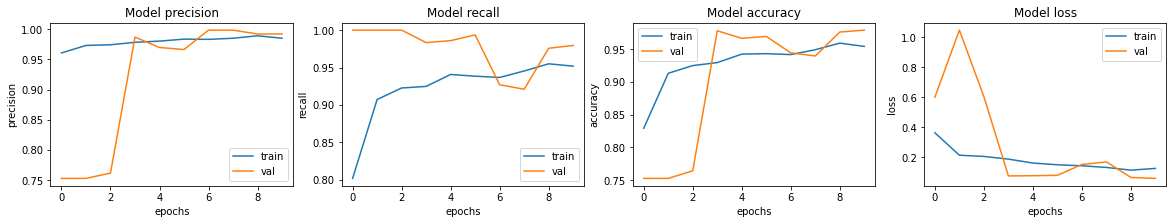

In [24]:
# Epochs 마다 모델의 precision, recall, accuracy, loss의 변화를 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
# performance metrics 값 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 128ms/step - loss: 0.6582 - accuracy: 0.7821 - precision: 0.7433 - recall: 0.9949
Loss: 0.6581717133522034,
Accuracy: 0.7820512652397156,
Precision: 0.7432950139045715,
Recall: 0.9948717951774597


## 8. 폐렴 진단기 성능 개선

기존 모델에서 성능 개선 가능한 부분
- ResNet-18 알고리즘 (residual block 추가)
- Data Agumentation
- 하피어 파라미터

### ResNet-18 알고리즘
ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.

ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

![residual_layer](https://d3s0tskafalll9.cloudfront.net/media/images/residual_connection.max-800x600.png)

In [39]:
def conv_block2(filters): # conv_block에서 strides = 2 추가
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, strides = 2, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, strides = 2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [49]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # 첫 번째
    x_shortcut = x
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 두 번째
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Residual Connection (Skip Connection) 추가
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

![ResNet](https://d3s0tskafalll9.cloudfront.net/media/images/resnet-18.max-800x600.png)

In [60]:
# Sequential 모델 생성
def build_model_res():
    model = tf.keras.Sequential()

    # Conv Block 1
    model.add(tf.keras.layers.Conv2D(16, kernel_size=7, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=2))          
              
    # Residual Block 2          
    model.add(residual_block(model.layers[-1], 32, stride=2))
    model.add(residual_block(model.layers[-1], 32))

    # Residual Block 3
    model.add(residual_block(model.layers[-1], 64, stride=2))
    model.add(residual_block(model.layers[-1], 64))

    # Residual Block 4
    model.add(residual_block(model.layers[-1], 128, stride=2))
    model.add(residual_block(model.layers[-1], 128))

    # Residual Block 5
    model.add(residual_block(model.layers[-1], 256, stride=2))
    model.add(residual_block(model.layers[-1], 256))

    # Average pooling과 Fully Connected 레이어 추가
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model = tf.keras.Model(inputs=input_tensor, outputs=x)

    return model

### Dara Augmentation
이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다. 그래서 augmentation 도입은 신중해야 합니다.
- 이미지 회전
- 가우시안 노이즈 추가

In [36]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    image = tf.image.random_jpeg_quality(image, 75, 95) # 노이즈 추가 (image, min_jpeg_quality, max_jpeg_quality, seed)
    return image,label

In [66]:
# 데이터 변환
def prepare_for_training_with_aug(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,       # augment 함수 적용
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치 설정
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

    return ds

train_ds_aug = prepare_for_training_with_aug(train_ds_orig)
val_ds_aug = prepare_for_training_with_aug(val_ds_orig)

### 하이퍼 파라미터 벤치마크
- BATCH_SIZE
- EPOCHS

In [ ]:
# 하이퍼 파라미터 두 변수
BATCH_SIZE = 16
EPOCHS = 10

## 시행착오

In [67]:
with tf.device('/GPU:0'): # GPU 선택
    model2 = build_model() # 미리 정한 model 선언

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam', # adam
        loss='binary_crossentropy', # 라벨이 2가지 뿐이라
        metrics=METRICS # accuracy, precision, recall
    )

# 변수, 데이터셋을 파라미터에 넣고 학습 fit 
with tf.device('/GPU:0'):
    history = model2.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        #epochs=EPOCHS,
        epochs=1,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

261/261 [==============================] - 66s 214ms/step - loss: 0.4026 - accuracy: 0.8199 - precision: 0.9489 - recall: 0.7996 - val_loss: 0.6687 - val_accuracy: 0.7519 - val_precision: 0.7519 - val_recall: 1.0000


In [68]:
# performance metrics 값 출력
loss2, accuracy2, precision2, recall2 = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 0.9627 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6581717133522034,
Accuracy: 0.7820512652397156,
Precision: 0.7432950139045715,
Recall: 0.9948717951774597
